# Compute optimal individual parameters for GMAC metric

In [526]:
from utilities import *
from functions.extract_mask_from_video import *
from classification_algorithms import compute_vector_magnitude
import GMAC as gmac

In [527]:
#CHANGE VALUES HERE TODO
# H for Healthy and S for Stroke 
participant_id = 'S009'
participant_group = 'S'
using_Axivity = True

In [528]:
#PATH# 
initial_path = '../data/CreateStudy'#'../CreateStudy'
participant_path = os.path.join(initial_path, participant_id)
print(participant_path)

../data/CreateStudy/S009


In [529]:
# Extract dataset from the participant JSON file 
participant_data = load_participant_json(participant_id, initial_path)
# Get the correct handiness 
dominant_hand = get_dominant_hand(participant_data) # For stroke, dominant hand = non affected hand 
# Add entry decribing whetere the dominant arm is affected by the stroke participant dataset
add_attributes_to_participant(participant_data, dominant_arm_affected= participant_data['dominant_hand']==participant_data['affected_hand'])

In [530]:
# Get the data from IMU csv files 
ndh_data, chest_data, dh_data, GT_mask_25Hz_NDH, GT_mask_25Hz_DH = get_data(participant_path, dominant_hand, using_Axivity)
GT_mask_25Hz_NDH = GT_mask_25Hz_NDH.ravel()
GT_mask_25Hz_DH = GT_mask_25Hz_DH.ravel()
# Ensure the array sizes consistency between masks and IMU data
print(len(GT_mask_25Hz_NDH)*2, len(ndh_data))

66930 66930


In [531]:
sampling_freq = 50 # Hz
frequency_GMAC = 1 # Hz
FPS_mask = 25 # Hz
frequency_euler_angles = 50 # Hz 

In [532]:
# Upsample GT (50 Hz)
GT_mask_NDH_50Hz = resample_mask(GT_mask_25Hz_NDH, FPS_mask, frequency_euler_angles)
GT_mask_DH_50Hz = resample_mask(GT_mask_25Hz_DH, FPS_mask, frequency_euler_angles)

In [533]:
# Get useful variables
acc_ndh = ndh_data[['acc_x', 'acc_y', 'acc_z']]
acc_dh = dh_data[['acc_x', 'acc_y', 'acc_z']]
gyro_ndh = ndh_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_dh = dh_data[['gyro_x', 'gyro_y', 'gyro_z']]
if not using_Axivity:
    mag_ndh = ndh_data[['magneto_x', 'magneto_y', 'magneto_z']]
    quat_sensor_ndh = ndh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
    quat_sensor_dh = dh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]

## compute GMAC Counts and Forearm Elevation

### Vector Magnitude


In [534]:
#https://github.com/biorehab/upper-limb-use-assessment/tree/main
df_for_Subash_ndh = ndh_data.rename(columns={'acc_x': 'ax', 'acc_y': 'ay', 'acc_z': 'az', 'gyro_x': 'gx', 'gyro_y': 'gy', 'gyro_z': 'gz'})
df_for_Subash_dh = dh_data.rename(columns={'acc_x': 'ax', 'acc_y': 'ay', 'acc_z': 'az', 'gyro_x': 'gx', 'gyro_y': 'gy', 'gyro_z': 'gz'})

# Convert timestamp column to datetime format (assuming 'timestamp' is in a suitable format)
df_for_Subash_ndh['timestamp'] = pd.to_datetime(df_for_Subash_ndh['timestamp'])
df_for_Subash_dh['timestamp'] = pd.to_datetime(df_for_Subash_dh['timestamp'])
# Set the index of the DataFrame to the timestamp column
df_for_Subash_ndh.set_index('timestamp', inplace=True)
df_for_Subash_dh.set_index('timestamp', inplace=True)
# Remove the time column
df_for_Subash_ndh.drop('time', axis=1, inplace=True)
df_for_Subash_dh.drop('time', axis=1, inplace=True)

counts_for_GMAC_ndh = np.array(compute_vector_magnitude(df_for_Subash_ndh, gravitation_compensation='VQF'))
counts_for_GMAC_dh = np.array(compute_vector_magnitude(df_for_Subash_dh, gravitation_compensation='VQF'))

/Users/linus/Code/imu_processing/src/classification_algorithms.py:62: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]
/Users/linus/Code/imu_processing/src/classification_algorithms.py:62: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]
/Users/linus/Code/imu_processing/src/classification_algorithms.py:110: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(1) + 'S').sum() for df in dfs]
/Users/linus/Code/imu_processing/src/classification_algorithms.py:62: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', lab

### Forearm Elevation
Formerly called pitch angle. The angle between the forearm and the horizontal plane.

In [535]:
from functions.VQFpitch import IMUPitchCalculator
# Left wrist
elevation_calculator_ndh = IMUPitchCalculator(acc_ndh.to_numpy().copy(), gyro_ndh.to_numpy().copy(), sampling_freq)
elevation_vqf_ndh = elevation_calculator_ndh.calculate_elevation()
elevation_ndh_50Hz = elevation_vqf_ndh
# Right wrist
elevation_calculator_dh = IMUPitchCalculator(acc_dh.to_numpy().copy(), gyro_dh.to_numpy().copy(), sampling_freq)
elevation_vqf_dh = elevation_calculator_dh.calculate_elevation()
elevation_dh_50Hz = elevation_vqf_dh

In [536]:
# Ensure the datasets have the same sizes 
# For ndh
elevation_ndh_50Hz, GT_mask_50Hz_ndh = remove_extra_elements(elevation_ndh_50Hz, GT_mask_NDH_50Hz)
# For dh
elevation_dh_50Hz, GT_mask_50Hz_dh = remove_extra_elements(elevation_dh_50Hz, GT_mask_DH_50Hz)

Arrays already had same shape.
Arrays already had same shape.


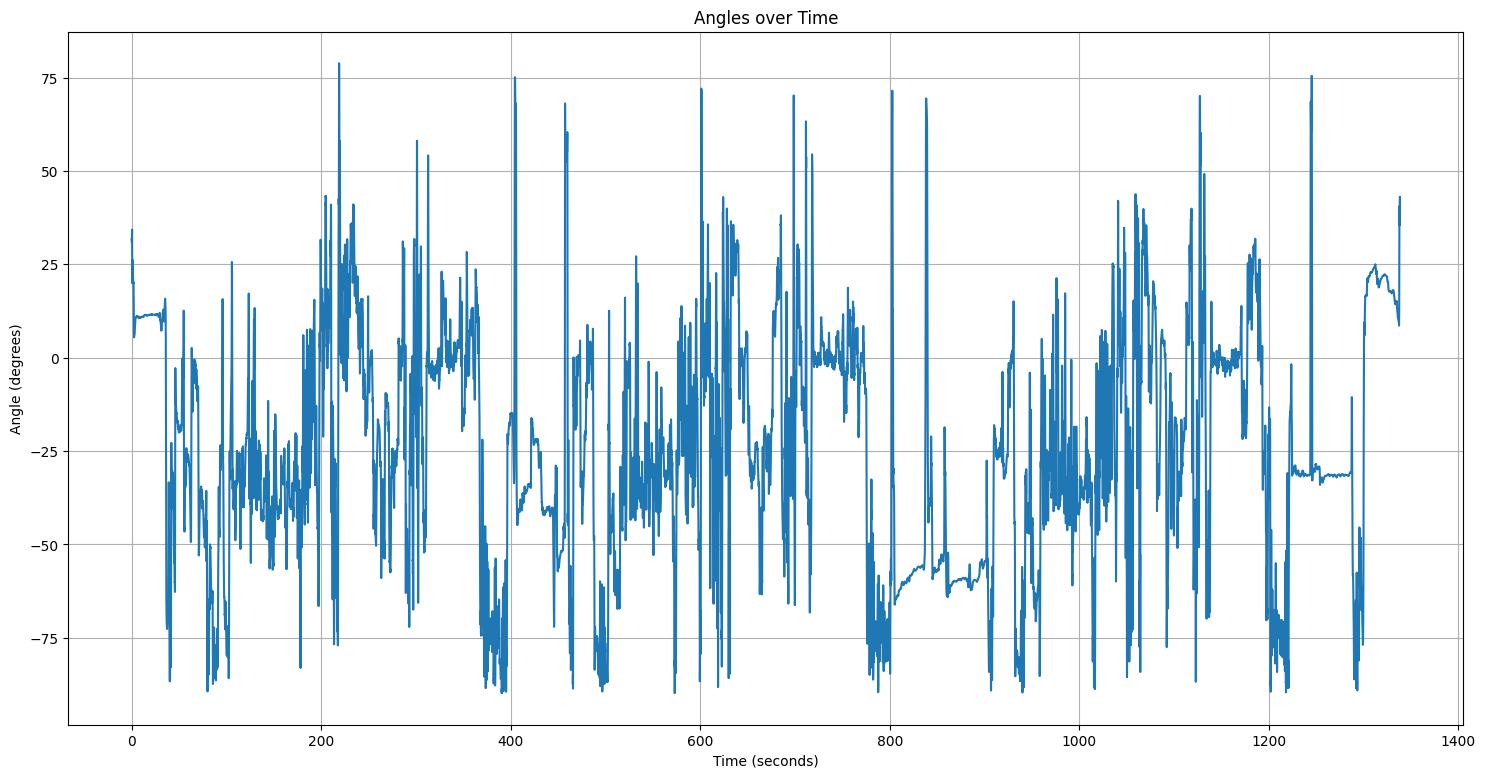

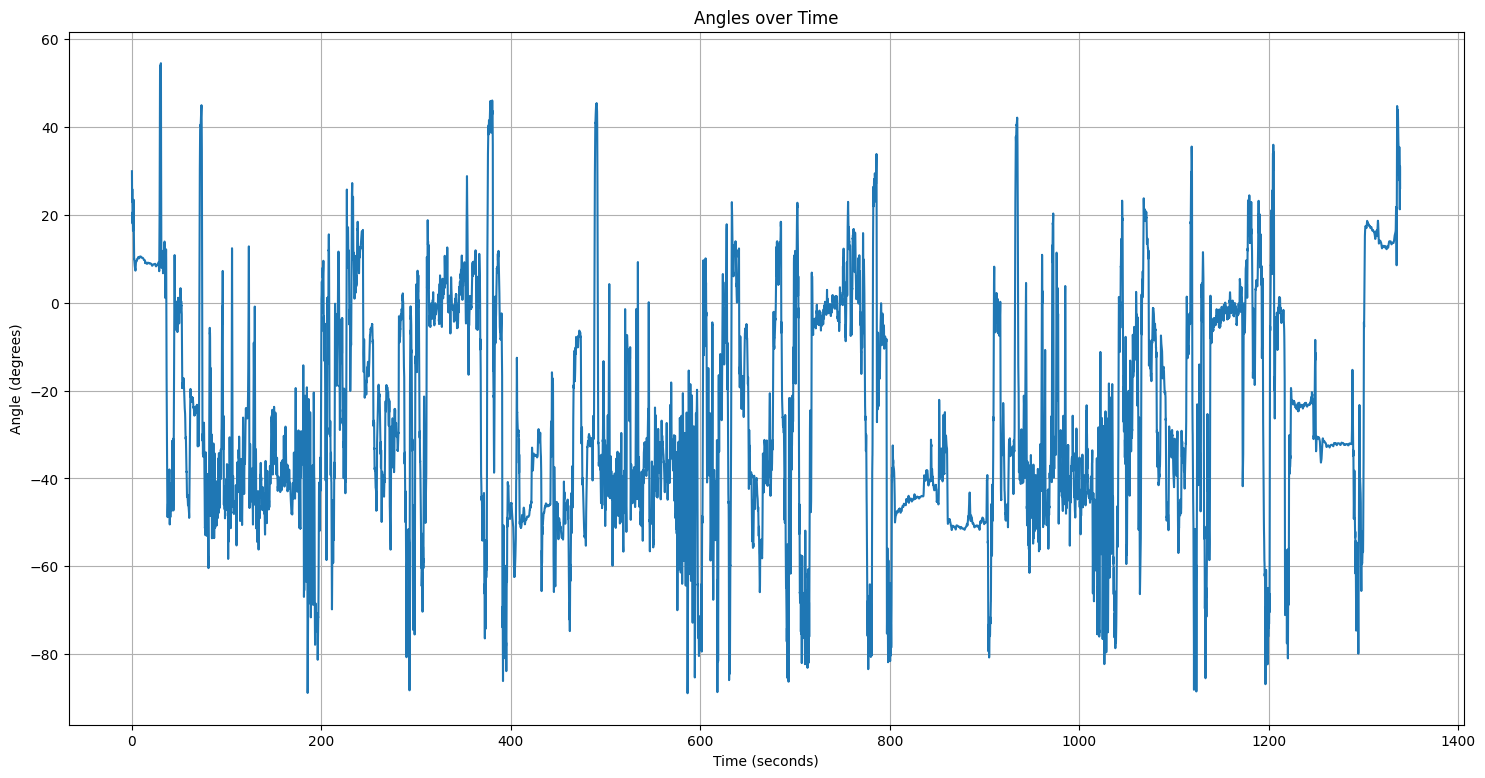

In [537]:
plot_angles_over_time(elevation_dh_50Hz)
plot_angles_over_time(elevation_ndh_50Hz)

In [538]:
# Add Euler angles to participant dataset
add_attributes_to_participant(participant_data, elevation_NDH_50Hz=elevation_ndh_50Hz, elevation_DH_50Hz=elevation_dh_50Hz)

Resample pitch to 1Hz

In [539]:
df_for_Subash_ndh['pitch'] = elevation_ndh_50Hz
df_for_Subash_dh['pitch'] = elevation_dh_50Hz

In [540]:
mean_pitch_NDH = gmac.resample(df_for_Subash_ndh[['pitch']], 50, 1)
mean_pitch_DH = gmac.resample(df_for_Subash_dh[['pitch']], 50, 1)

/Users/linus/Code/imu_processing/src/GMAC.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]
/Users/linus/Code/imu_processing/src/GMAC.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]


### GT MASK Resampling & dropping of excluded frames

In [541]:
# Replace all WBM (whole-body movements) by NF movements inside the GT mask @ 25 Hz 
# Could be changed in the future (e.g. remove all WBM movements)
GT_mask_NDH_25Hz = replace_wbm_with_nf(GT_mask_25Hz_NDH).ravel()
GT_mask_DH_25Hz = replace_wbm_with_nf(GT_mask_25Hz_DH).ravel()

In [542]:
# Downsample GT masks to be used later on for GMAC (1Hz) computation
GT_mask_NDH_1Hz = downsample_mask(GT_mask_NDH_25Hz, FPS_mask, frequency_GMAC)
GT_mask_DH_1Hz = downsample_mask(GT_mask_DH_25Hz, FPS_mask, frequency_GMAC)

In [543]:
# Downsample task mask to 1Hz
task_mask_ndh_1Hz = downsample_mask(participant_data['task_mask_25Hz'], FPS_mask, frequency_GMAC)
task_mask_dh_1Hz = downsample_mask(participant_data['task_mask_25Hz'], FPS_mask, frequency_GMAC)

In [544]:
# Ensure GT Mask @ 1 hZ have same size as the vector magnitude values 
GT_mask_NDH_1Hz, counts_for_GMAC_ndh = remove_extra_elements(GT_mask_NDH_1Hz, counts_for_GMAC_ndh)
GT_mask_DH_1Hz, counts_for_GMAC_dh = remove_extra_elements(GT_mask_DH_1Hz, counts_for_GMAC_dh)
# Ensure GT Mask @ 1 hZ have same size as the pitch values
GT_mask_NDH_1Hz, mean_pitch_NDH = remove_extra_elements(GT_mask_NDH_1Hz, mean_pitch_NDH)
GT_mask_DH_1Hz, mean_pitch_DH = remove_extra_elements(GT_mask_DH_1Hz, mean_pitch_DH)
GT_mask_NDH_1Hz, counts_for_GMAC_ndh = remove_extra_elements(GT_mask_NDH_1Hz, counts_for_GMAC_ndh)
GT_mask_DH_1Hz, counts_for_GMAC_dh = remove_extra_elements(GT_mask_DH_1Hz, counts_for_GMAC_dh)
# Ensure task Mask @ 1 hZ has same size as GT mask
task_mask_ndh_1Hz, GT_mask_NDH_1Hz = remove_extra_elements(task_mask_ndh_1Hz, GT_mask_NDH_1Hz)
task_mask_dh_1Hz, GT_mask_DH_1Hz = remove_extra_elements(task_mask_dh_1Hz, GT_mask_DH_1Hz)

Array 2 has been trimmed to size 1339.
Array 2 has been trimmed to size 1339.
Array 2 has been trimmed to size 1339.
Array 2 has been trimmed to size 1339.
Arrays already had same shape.
Arrays already had same shape.
Arrays already had same shape.
Arrays already had same shape.


remove excluded frames

In [545]:
counts_for_GMAC_ndh, mean_pitch_NDH, task_mask_for_GMAC_NDH_1Hz, GT_mask_NDH_1Hz = remove_excluded_frames(counts_for_GMAC_ndh, mean_pitch_NDH, task_mask_ndh_1Hz, GT_mask_NDH_1Hz)
counts_for_GMAC_dh, mean_pitch_DH, task_mask_for_GMAC_DH_1Hz, GT_mask_DH_1Hz = remove_excluded_frames(counts_for_GMAC_dh, mean_pitch_DH, task_mask_dh_1Hz, GT_mask_DH_1Hz)

remove nan frames due to filtering in counts

In [546]:
counts_for_GMAC_ndh, mean_pitch_NDH, task_mask_for_GMAC_NDH_1Hz, GT_mask_NDH_1Hz = remove_nan_frames(counts_for_GMAC_ndh, mean_pitch_NDH, task_mask_for_GMAC_NDH_1Hz, GT_mask_NDH_1Hz)
counts_for_GMAC_dh, mean_pitch_DH, task_mask_for_GMAC_DH_1Hz, GT_mask_DH_1Hz = remove_nan_frames(counts_for_GMAC_dh, mean_pitch_DH, task_mask_for_GMAC_DH_1Hz, GT_mask_DH_1Hz)

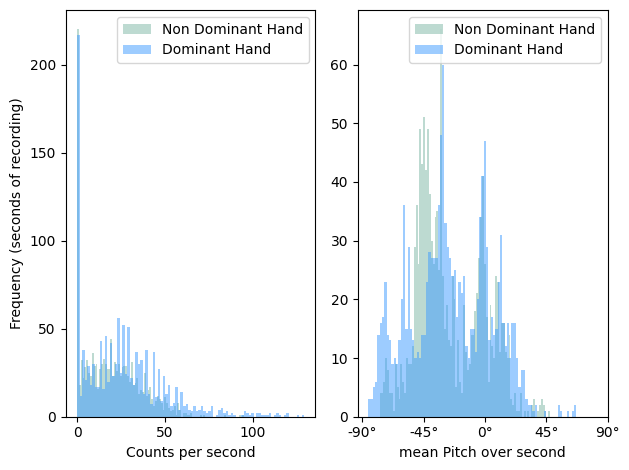

In [547]:
import matplotlib.pyplot as plt

# Plot histogram for counts_for_GMAC
plt.subplot(1, 2, 1)
plt.hist(counts_for_GMAC_ndh, bins=90, color=thesis_style.get_thesis_colours()['turquoise'], alpha=0.5, label='Non Dominant Hand')
plt.hist(counts_for_GMAC_dh, bins=90, color=thesis_style.get_thesis_colours()['dark_blue'], alpha=0.5, label='Dominant Hand')
plt.xlabel('Counts per second')
plt.ylabel('Frequency (seconds of recording)')
plt.legend()

# Plot histogram for mean_pitch
plt.subplot(1, 2, 2)
plt.hist(mean_pitch_NDH['pitch'], bins=90, color=thesis_style.get_thesis_colours()['turquoise'], alpha=0.5, label='Non Dominant Hand')
plt.hist(mean_pitch_DH['pitch'], bins=90, color=thesis_style.get_thesis_colours()['dark_blue'], alpha=0.5, label='Dominant Hand')
plt.xticks([-90, -45, 0, 45, 90], ['-90°', '-45°', '0°', '45°', '90°'])
plt.xlabel('mean Pitch over second')
plt.legend()

plt.tight_layout()
plt.show()

In [548]:
# Update the participant dataset file with new arrays of usefull data  
# Add processed (removed excluded, ...) vector magnitude and elevation
add_attributes_to_participant(participant_data, counts_for_GMAC_ndh_1Hz=counts_for_GMAC_ndh, counts_for_GMAC_dh_1Hz=counts_for_GMAC_dh, 
                              pitch_for_GMAC_ndh_1Hz=mean_pitch_NDH['pitch'].values, pitch_for_GMAC_dh_1Hz=mean_pitch_DH['pitch'].values)
# Add mask @ 1 Hz and @ 25 Hz
add_attributes_to_participant(participant_data, GT_mask_NDH_1Hz = GT_mask_NDH_1Hz, GT_mask_DH_1Hz = GT_mask_DH_1Hz, 
                             GT_mask_NDH_25Hz = GT_mask_NDH_25Hz, GT_mask_DH_25Hz = GT_mask_DH_25Hz, 
                             task_mask_for_GMAC_NDH_1Hz=task_mask_for_GMAC_NDH_1Hz, task_mask_for_GMAC_DH_1Hz=task_mask_for_GMAC_DH_1Hz)

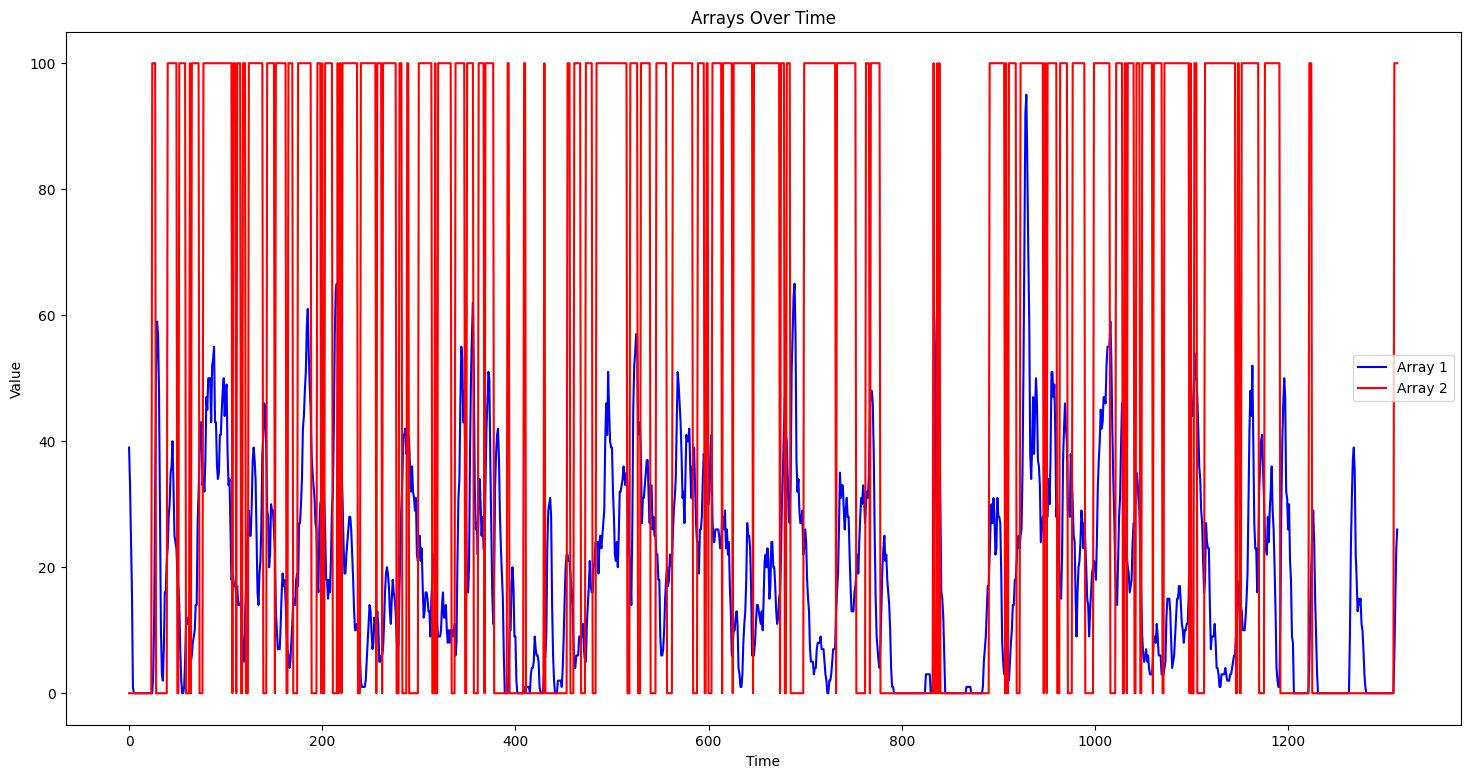

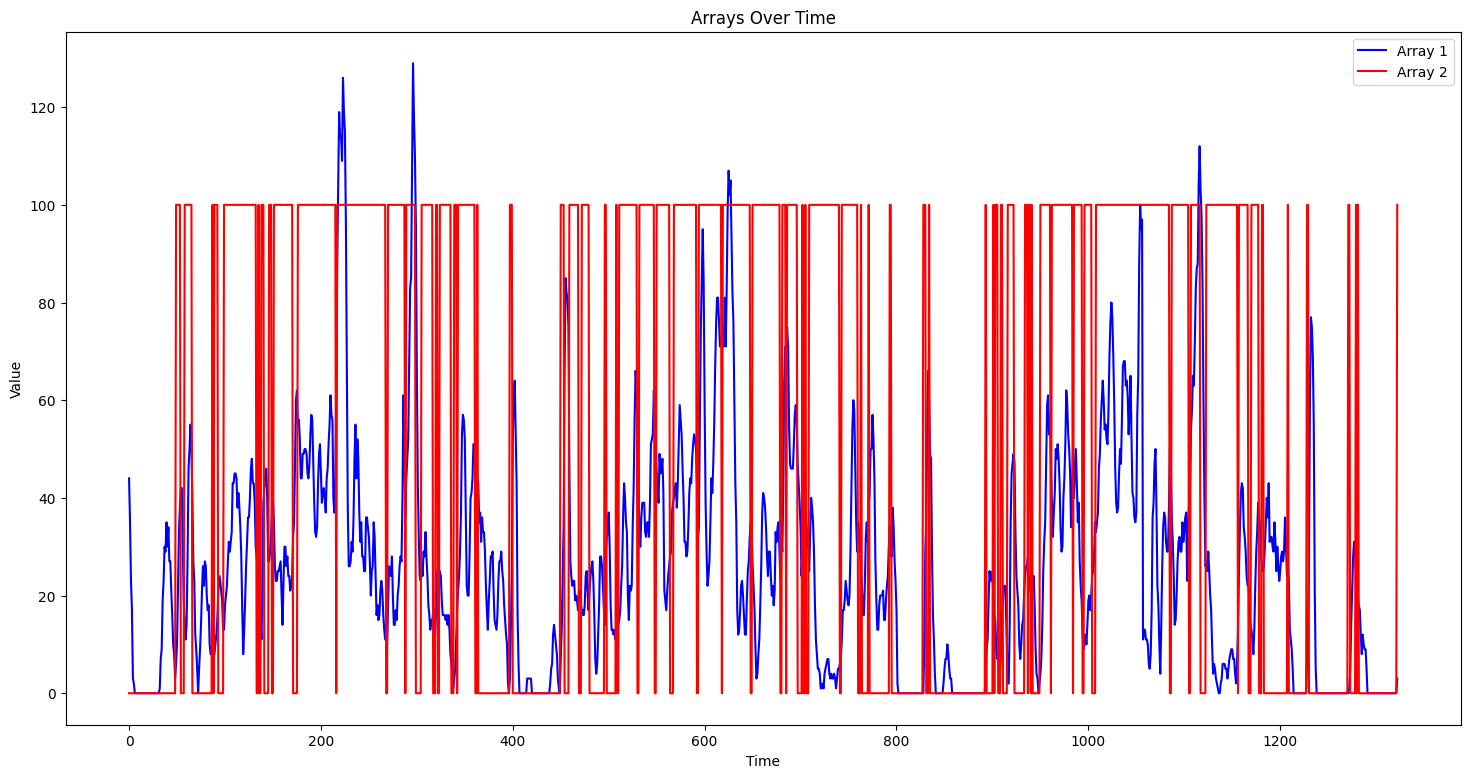

In [549]:
# Plot to visualize counts and GT superposed
plot_superposition(counts_for_GMAC_ndh, 100*GT_mask_NDH_1Hz)
plot_superposition(counts_for_GMAC_dh, 100*GT_mask_DH_1Hz)

## Balance Dataset

In [550]:
#TODO balance the dataset

## Individual Optimization

In [551]:
from functions.individual_analysis_gmac_function import *

In [552]:
# Perform k-fold cross-validation for the left wrist data
# Return average optimal Count threshold, Pitch threshold and evaluation metrics on this optimal parameter when tested against GT
eval_metrics_opt_ndh, opt_thresholds_ndh, min_max_std_threshold_ndh = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_ndh.ravel(), mean_pitch_NDH['pitch'].values), axis=0).T, y=GT_mask_NDH_1Hz, optimal=True)
# Same but for conventional fixed threshold 
eval_metrics_conv_ndh, conv_thresholds_ndh, _ = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_ndh.ravel(), mean_pitch_NDH['pitch'].values), axis=0).T, y=GT_mask_NDH_1Hz, optimal=False)

Arrays already had same shape.
Iteration 1/5
Optimal Count Threshold: 1.00
Optimal Pitch Threshold: 45.00
Iteration 2/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 45.00
Iteration 3/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 45.00
Iteration 4/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 45.00
Iteration 5/5
Optimal Count Threshold: 1.00
Optimal Pitch Threshold: 55.00
Arrays already had same shape.
Iteration 1/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 2/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 3/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 4/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 5/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00


In [553]:
# Perform k-fold cross-validation for the right wrist data
# Return average optimal Count threshold, Pitch threshold and evaluation metrics on this optimal parameter when tested against GT
eval_metrics_opt_dh, opt_thresholds_dh, min_max_std_threshold_dh = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_dh, mean_pitch_DH['pitch'].values), axis=0).T, y=GT_mask_DH_1Hz, optimal=True)
# Same but for conventional fixed threshold
eval_metrics_conv_dh, conv_thresholds_dh, _ = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_dh, mean_pitch_DH['pitch'].values), axis=0).T, y=GT_mask_DH_1Hz, optimal=False)

Arrays already had same shape.
Iteration 1/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 41.00
Iteration 2/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 41.00
Iteration 3/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 42.00
Iteration 4/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 44.00
Iteration 5/5
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 42.00
Arrays already had same shape.
Iteration 1/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 2/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 3/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 4/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 5/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00


In [554]:
# Optimal Count and Pitch thresholds for this participant
print("Non Dominant Hand")
print(opt_thresholds_ndh)
print(min_max_std_threshold_ndh) #min, max, std over k-folds
print("Dominant Hand")
print(opt_thresholds_dh)
print(min_max_std_threshold_dh) #min, max, std over k-folds

Non Dominant Hand
(0.4, 47.0)
({'min': 0.0, 'max': 1.0, 'std': 0.48989794855663565}, {'min': 45.0, 'max': 55.0, 'std': 4.0})
Dominant Hand
(0.0, 42.0)
({'min': 0.0, 'max': 0.0, 'std': 0.0}, {'min': 41.0, 'max': 44.0, 'std': 1.0954451150103321})


In [555]:
# Create a structure to save all the evaluation metrics 
metrics_dictionary_GMAC = create_metrics_dictionary(eval_metrics_conv_ndh, eval_metrics_conv_dh, eval_metrics_opt_ndh, eval_metrics_opt_dh)

In [556]:
metrics_dictionary_GMAC

{'OT_ndh_Sensitivity': 86.2299127726313,
 'OT_ndh_Specificity': 57.9733360891046,
 'OT_ndh_Accuracy': 74.20456854265231,
 'OT_ndh_YoudenIndex': 0.4420324886173589,
 'OT_dh_Sensitivity': 90.19615627159537,
 'OT_dh_Specificity': 74.24093145589185,
 'OT_dh_Accuracy': 83.14179531160664,
 'OT_dh_YoudenIndex': 0.6443708772748722,
 'CT_ndh_Sensitivity': 55.06198787946143,
 'CT_ndh_Specificity': 83.49220624112552,
 'CT_ndh_Accuracy': 67.04989405857255,
 'CT_ndh_YoudenIndex': 0.3855419412058694,
 'CT_dh_Sensitivity': 70.97711571365474,
 'CT_dh_Specificity': 82.40161111453271,
 'CT_dh_Accuracy': 76.0360205831904,
 'CT_dh_YoudenIndex': 0.5337872682818745}

In [557]:
# Add metrics for GMAC threshold evaluation to the JSON file 
add_attributes_to_participant(participant_data, metrics_dictionary_GMAC = metrics_dictionary_GMAC) 
# Add optimal GMAC parameter to the JSON file 
add_attributes_to_participant(participant_data, optimal_GMAC_NDH = opt_thresholds_ndh, optimal_GMAC_DH = opt_thresholds_dh) 
# Add min, max and std of the optimal GMAC parameter to the JSON file
add_attributes_to_participant(participant_data, min_max_std_GMAC_NDH = min_max_std_threshold_ndh, min_max_std_GMAC_DH = min_max_std_threshold_dh)

In [558]:
# Save the JSON file with the new fields 
save_to_json(participant_data, participant_path)

Data saved to: ../data/CreateStudy/S009/S009.json
